In [2]:
from utils import *


PATH = '../data/archive/cars.csv'


data = read_data_2(PATH)

N = data.shape[0] # number of alternatives
K = data.shape[1] - 1 # number of criteria
A = data.values[:, 1:] # alternatives matrix
# A = normalize_matrix_columns(A) # normalize the matrix

P = np.zeros((1, K)) # preference thresholds list for each criteria
Q = np.zeros((1, K)) # indifference thresholds list for each criteria
W = np.ones((1, K)) # weights of each criterias


P[0, :] = [0.9, 0.9, 0.9, 0.9, 0.9] # preference parameters
Q[0, :] = [0.1, 0.1, 0.1, 0.1, 0.1] # indifference parameters
W[0, :] = [0.2, 0.2, 0.2, 0.2, 0.2] # weights of each criterias

T_I = 0.3 # Global indifference threshold
T_J= T_I# Global incomparability threshold
P_F = 10 # Global preference factor



def linear_Pk(ai, aj, c):
    """
        Pk(a,b) for criteria k=c
        ai, aj: alternatives i and j: an array of criteria values
        c: criteria
        Returns the value of the preference function for criteria c
    """
    dk = ai[c] - aj[c]
    if dk < Q[0, c]: # if ai is indifferent to aj
        return 0
    if dk > P[0, c]:
        return 1
    return (dk - Q[0, c]) / (P[0, c] - Q[0, c])

def phi_c(ai, A, c):
    """
        phi_c(ai, A) for criteria c = mono criterion net flow score of alternative a_i for criteria c
        A: alternatives matrix
        c: criteria
        phi_c(ai, A) = sum(W[c] * linear_Pk(ai, aj, c) for aj in A)
    """
    return 1/ (N-1) * sum([(linear_Pk(ai, aj, c) - linear_Pk(aj, ai, c)) for aj in A])

def matrices_phi(A):
    """
        Returns the phi matrix for all criteria
        - Each column represents a criteria
        - Each row represents an alternative
        - Each cell represents the mono criterion net flow score of alternative a_i for criteria c
    """
    return np.array([[phi_c(ai, A, c) for c in range(K)] for ai in A])

def matrice_gamma(A):
    """
        Returns the gamma matrix
        - Each column represents an alternative
        - Each row represents an alternative
        - Each cell represents gamma(a_i, a_j) = sum(W[c] * (phi_c(ai, A, c) - phi_c(aj, A, c)) for c in range(K)) if ai > aj for criteria c
    """
    A_phi = matrices_phi(A)
    gamma = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            for c in range(K):
                if A[i, c] > A[j, c]:
                    gamma[i, j] += W[0, c] * (A_phi[i, c] - A_phi[j, c])
    return gamma

def plot_gamma_on_graph(gamma):
    """
        Plot the gamma matrix on a graph
        - x axis = gamma ij
        - y axis = gamma ji
    """
    fig, ax = plt.subplots()
    ax.scatter(gamma, gamma.T)
    ax.set_xlabel('Gamma_ij')
    ax.set_ylabel('Gamma_ji')

    # add TI and TJ lines (horizontal and vertical)
    ax.axhline(y=T_I, color='r', linestyle='--')
    ax.axvline(x=T_I, color='r', linestyle='--')

    plt.show()

def compute_indicators(gamma):
    """"
    Function that computes the matrix of indicators I, J and P of size N x N (N = number of alternatives)
    """
    I = np.zeros((N, N))
    J = np.zeros((N, N))
    P = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            I[i, j] = T_I - max(gamma[i, j], gamma[j, i])
            J[i, j] = min(gamma[i, j], gamma[j, i]) - T_J
            P[i, j] = (gamma[i, j] - gamma[j, i])/P_F
            P[j, i] = (gamma[j, i] - gamma[i, j])/P_F
    return I, J, P

gamma = matrice_gamma(A)
I, J, P = compute_indicators(gamma)


def select_relation(I, J, P, gamma):
    """
        Select the relation between two alternatives
        Returns the matrices Is, Js, Ps of size N x N (N = number of alternatives) with the values of gamma only for the selected relation
    """
    Is = np.zeros((N, N))
    Js = np.zeros((N, N))
    Ps = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if I[i, j] > max(J[i, j], P[i, j], P[j, i]):
                Is[i, j] = gamma[i, j]
            elif J[i, j] > max(I[i, j], P[i, j], P[j, i]):
                Js[i, j] = gamma[i, j]
            elif P[i, j] > max(I[i, j], J[i, j], P[j, i]):
                Ps[i, j] = gamma[i, j]
            elif P[j, i] > max(I[i, j], J[i, j], P[i, j]):
                Ps[i, j] = gamma[i, j]
    return Is, Js, Ps


def plot_gamma_on_graph(Is, Js, Ps):
    """
        Plot the gamma matrix on a graph
        - x axis = gamma ij
        - y axis = gamma ji
        different colors for each relation
        relations = matrix of tuples (gamma_ij, relation)
    """
    fig, ax = plt.subplots()
    ax.scatter(Is, Is.T, color='b', label='I')
    ax.scatter(Js, Js.T, color='r', label='J')
    ax.scatter(Ps, Ps.T, color='g', label='P')
    ax.set_xlabel('Gamma_ij')
    ax.set_ylabel('Gamma_ji')
    ax.legend()

    # add TI and TJ lines (horizontal and vertical)
    ax.axhline(y=T_I, color='r', linestyle='--')
    ax.axvline(x=T_I, color='r', linestyle='--')

    plt.show()

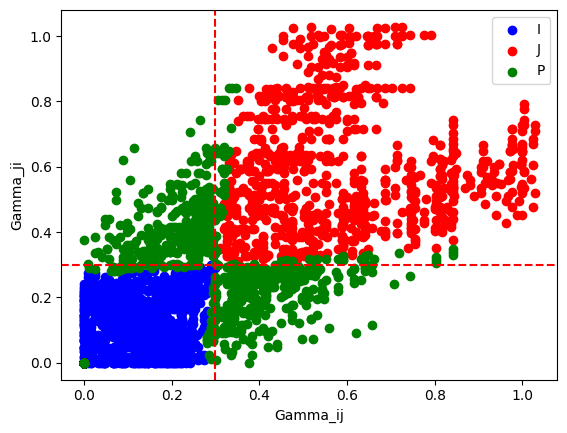

array([[0.        , 0.16734694, 0.0244898 , ..., 0.29795918, 0.20408163,
        0.3755102 ],
       [0.15102041, 0.        , 0.08571429, ..., 0.38367347, 0.20816327,
        0.37959184],
       [0.17142857, 0.24897959, 0.        , ..., 0.29795918, 0.20408163,
        0.3755102 ],
       ...,
       [0.30612245, 0.40816327, 0.15918367, ..., 0.        , 0.19591837,
        0.33877551],
       [0.19183673, 0.2122449 , 0.04489796, ..., 0.1755102 , 0.        ,
        0.21632653],
       [0.14693878, 0.16734694, 0.        , ..., 0.10204082, 0.        ,
        0.        ]])

In [3]:
Is, Js, Ps = select_relation(I, J, P, gamma)
plot_gamma_on_graph(Is, Js, Ps)
gamma